In [1]:
osi_threshold = 0.4
#dsi_threshold = 0.5
#tf_for_dsi_calc = 2.0
ecid = 511510650
eid = 501836392
# 501836392 501886692 501717543

# Events or dff
use_events = True
# Only pairs that are closer than these frames will be considered.
# For reference, ko 2011 did 50um. Each 512 pixel field of view is 400 um. 64frames =50um.
max_d = 64
# corr_type = TEMP_CORR_AVG, AVG_TEMP_CORR, NOISE_CORR
# Ho ko 2011 used TEMP_CORR_AVG for signal correlation.
# "Signal correlation was calculated as the correlation coefficient of the average responses to stimulus."
# Then, NOISE_CORR for noise correlation.
# "Noise correlation was found by subtracting the average response from the responses"
corr_type = 'TEMP_CORR_AVG'


In [2]:
import os
drive_path = '/media/stephen/Brain20191/allen-brain-observatory/visual-coding-2p/'
if not os.path.isdir(drive_path):
    drive_path = '/media/alihamodi/Brain2019/allen-brain-observatory/visual-coding-2p/'

import warnings; warnings.simplefilter('ignore');
from utils.polarplot import *
from utils.polardata import *
from utils.data_wrappers import *
import os
import pandas as pd
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import allensdk.brain_observatory.stimulus_info as stim_info
manifest_file = os.path.join(drive_path,'manifest.json')
boc = BrainObservatoryCache(manifest_file=manifest_file)

import warnings;
warnings.simplefilter('ignore');
cells = boc.get_cell_specimens()
cells = pd.DataFrame.from_records(cells)
    
# Outputs = [cell_specimen_id, experiment_container_id, pref_dir]


In [11]:
pd.DataFrame(boc.get_ophys_experiments(experiment_container_ids=[ecid]))

,acquisition_age_days,cre_line,donor_name,experiment_container_id,fail_eye_tracking,id,imaging_depth,reporter_line,session_type,specimen_name,targeted_structure
0,109,Cux2-CreERT2,222425,511510650,False,501886692,175,Ai93(TITL-GCaMP6f),three_session_B,Cux2-CreERT2;Camk2a-tTA;Ai93-222425,VISp
1,108,Cux2-CreERT2,222425,511510650,True,501836392,175,Ai93(TITL-GCaMP6f),three_session_A,Cux2-CreERT2;Camk2a-tTA;Ai93-222425,VISp
2,104,Cux2-CreERT2,222425,511510650,True,501717543,175,Ai93(TITL-GCaMP6f),three_session_C,Cux2-CreERT2;Camk2a-tTA;Ai93-222425,VISp


In [27]:
# filtered_cells.columns
filtered_cells['pref_ori'].unique()

array([ 60.,  30.,   0., 150., 120.,  90.])

In [4]:
dg_response_filter = get_dg_response_filter_from_saskia()
filtered_cells = get_filtered_cells(cells, dg_response_filter)
filtered_cells = filtered_cells[filtered_cells.experiment_container_id==ecid]
data_set = boc.get_ophys_experiment_data(eid)


# Filter out based on tf-specific-dsi, rather than allen's global dsi
# Also recalculate preferred direction using specific tf.
"""
tf_specific_dsi_col = []
tf_specific_pref_dir_col = []
for index, row in filtered_cells.iterrows():
    polardata_for_this_cell = get_avg_normalized_response(
        data_set = data_set,
        cell_specimen_id = row.cell_specimen_id,
        temporal_frequency = tf_for_dsi_calc)
    if polardata_for_this_cell is None:
        # Put negative value so dsi selector will ignore this guy.
        new_dsi_cell = -1
    else:
        new_dsi_cell = get_new_dsi(polardata_for_this_cell.to_frame())
    tf_specific_dsi_col.append(new_dsi_cell)
    tf_specific_pref_dir_col.append(polardata_for_this_cell.argmax())
filtered_cells['tf_specific_dsi'] = tf_specific_dsi_col
filtered_cells['pref_dir'] = tf_specific_pref_dir_col
"""
# TODO: recompute this manually at a specific phase.
filtered_cells['pref_ori'] = filtered_cells['pref_ori_sg'] 
# TODO: Do filtering by both osi and dsi threshold. Ko 2011 uses both. 
filtered_cells = filtered_cells[filtered_cells.osi_sg > osi_threshold]

dirs = [0.0, 30.0, 60.0, 90.0, 120.0, 150.0]

angle_to_cell_groups = {}
for d in dirs:
    angle_to_cell_groups[d] = filtered_cells[filtered_cells.pref_ori == d].cell_specimen_id.values
    print(d, angle_to_cell_groups[d])

dirs_to_avg_pairwise_corr = {}
for d1 in dirs:
    for d2 in dirs:
        if len(angle_to_cell_groups[d1]) == 0 or len(angle_to_cell_groups[d2]) == 0:
            continue
        corrs, num_group1, num_group2 = pairwise_dir_avg_temp_corr_one_exp(
            boc, eid,
            angle_to_cell_groups[d1],
            angle_to_cell_groups[d2],
            max_d,
            use_events,
            corr_type)
        if corrs is None:
            continue
        dirs_to_avg_pairwise_corr[(d1, d2)] = corrs
        print ("d1", d1, "d2", d2, "num_pairs", len(corrs), "num_group1", num_group1, "num_group2", num_group2,
              "corrs", corrs)

0.0 [517419302 517419723 517419738 517420014 517420052 517420718 517420735
 517421150 517421666 586183202]
30.0 [517419288 517419310 517419927 517420158 517420275 517420573 517421502
 517421717 586181540 586183081 586183175]
60.0 [517419280 517419817 517419827 517420694]
90.0 [517419746 517419753 517419807 517419837 517420087 517420102 517420179
 517420380]
120.0 [517419703 517419772 517420741 517421141 517421374 586183132 586183153
 586183159]
150.0 [517419306 517419419 517420095 517420418 517421693 586182529]
d1 0.0 d2 0.0 num_pairs 4 num_group1 10 num_group2 10 corrs [-0.028112784332350774, -0.002166612126711318, -0.002166612126711318, -0.028112784332350774]
d1 0.0 d2 30.0 num_pairs 11 num_group1 10 num_group2 11 corrs [0.04251643003498079, 0.016131174378048882, -0.011521322203188048, 0.14182673954765704, 0.022584463576281744, 0.001952883941156057, -0.023153117230172104, 0.06986908064744657, 0.011579934585122922, 0.023530846669737357, -0.003867604910922938]
d1 0.0 d2 60.0 num_pairs 

In [19]:
from scipy import stats
angle_dist_to_corrs = {}
for dir_pair, corrs in dirs_to_avg_pairwise_corr.items():
    hi = max(dir_pair[0],dir_pair[1])
    lo = min(dir_pair[0],dir_pair[1])
    angle_dist = hi-lo
    if angle_dist > 90:
        angle_dist = 180-angle_dist
    if angle_dist not in angle_dist_to_corrs:
        angle_dist_to_corrs[angle_dist] = []
    angle_dist_to_corrs[angle_dist].extend(corrs)
for angle_dist, corrs in angle_dist_to_corrs.items():
    print(angle_dist, min(corrs), max(corrs), np.mean(corrs), np.std(corrs), len(corrs))
    

0.0 -0.04336700668622405 0.2028066463575427 0.02471562948442509 0.07602465200776444 16
30.0 -0.05065972573586701 0.23535621108831592 0.02721850004810024 0.061198450041048076 48
60.0 -0.03596729872590461 0.1108754968063067 0.01333750007218746 0.03778644409698752 44
90.0 -0.06862537093255235 0.041146153948109804 -0.013525538346777352 0.028261456205109687 26


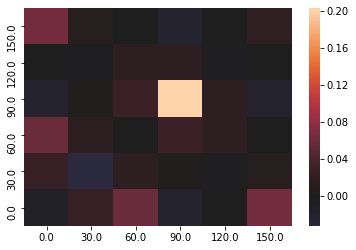

In [35]:
import seaborn as sns;
ser = pd.Series(list(dirs_to_avg_pairwise_corr.values()),
                  index=pd.MultiIndex.from_tuples(dirs_to_avg_pairwise_corr.keys()))
df = ser.unstack().fillna(0)
df = df.sort_index(axis=0 ,ascending=False)
sns.heatmap(df, center=0)

In [36]:
# For each angle, which angle groups are most correlated with it?
for dir1 in dirs:
    dir_partner_to_corr = {}
    for dir2 in dirs:
        key = (dir1, dir2)
        if key in dirs_to_avg_pairwise_corr:
            dir_partner_to_corr[dir2] = dirs_to_avg_pairwise_corr[key]
    desc_sorted_keys = sorted(dir_partner_to_corr, key=dir_partner_to_corr.get, reverse=True)
    print (dir1, desc_sorted_keys)
# The orderings are:
# For 501836392: [2,4,1,1,4,2,3], not bad, for a length of 8. mean ~2.43 ordering.
#   And.. that was when I was using allen dsi. When using our dsi, it got worse :(
# For 501886692: [6,5,7,2,2,3] - v bad
# For 501717543: [7,7,6,7,2] - v bad

0.0 [150.0, 60.0, 30.0, 120.0, 0.0, 90.0]
30.0 [0.0, 60.0, 150.0, 90.0, 120.0, 30.0]
60.0 [0.0, 90.0, 120.0, 30.0]
90.0 [90.0, 60.0, 120.0, 30.0, 0.0, 150.0]
120.0 [60.0, 90.0, 0.0, 120.0, 30.0]
150.0 [0.0, 150.0, 30.0, 90.0]
